# Q1

What does it mean for a function to be K-Lipschitz? What does it mean intuitively? Try to draw a simple 1-Lipschitz function.

(-0.9424777960769379,
 19.792033717615695,
 -1.0952455187017391,
 1.0997735961286543)

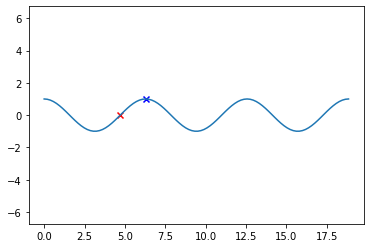

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 6*np.pi, 100)
y = np.cos(x)
plt.plot(x, y)
plt.scatter(1.5*np.pi, np.cos(1.5*np.pi), c="r", marker="x")
plt.scatter(2*np.pi, np.cos(2*np.pi), c="b", marker="x")
plt.axis("equal")

# Q2

What is Earth-Mover distance? Do you think we can compute EM in a feasible way?

# Q3

Does WGAN-GP really enforce 1-Lipschitz, or something more restrictive?

$$(\|\nabla_x C(x)\| - 1)^2$$

# Q4 - WGAN Implementation

Like the last week, we are going to implement a WGAN with gradient penalty (also called WGAN-GP) with PyTorch on a mock data. Most of the code is implemented for you. You are going to fill areas with `# >`.

In [9]:
from IPython.display import HTML
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [18]:
def gradient_penalty(critic, x_true, x_fake, derivative):
    if len(x_true.shape) == 2:
        alpha = torch.rand(x_true.size()[0],1, device=x_true.device)
    else:
        alpha = torch.rand(x_true.size()[0],1,1,1, device=x_true.device)

    alpha = alpha.expand(x_true.size())
    interpolates = alpha * x_true + (1-alpha) * x_fake
    interpolates = torch.autograd.Variable(interpolates,requires_grad=True)
    crit_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(outputs=crit_interpolates,
                                    inputs=interpolates,
                                    grad_outputs=torch.ones(crit_interpolates.size(), device=x_true.device),
                                    create_graph=True,
                                    retain_graph=True,
                                    only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2,dim=1)-derivative) ** 2).mean() * 10
    return gradient_penalty

In [19]:
def sample_from_img(n, img_url):
    # img_url must contain a black and white png image
    img = plt.imread(img_url)
    assert len(img.shape) == 2
    shape = np.array(img.shape)

    samples = []
    while len(samples) != n:
        x = np.random.rand(2)
        x_hat = (x * shape).astype(int)
        x_hat[0] = np.clip(x_hat[0], 0, shape[0]-1)
        x_hat[1] = np.clip(x_hat[1], 0, shape[1]-1)
        if np.random.rand() < img[shape[0]-x_hat[0]-1, x_hat[1]]:
            # add a normalized sample
            x_n = x*2-1
            samples.append([x_n[1], x_n[0]])
    samples = np.array(samples)
    return samples

def sample_swissroll(N):
    r = torch.sqrt(torch.linspace(0, 1, N)) * 780 * (2*np.pi)/360
    dx = -torch.cos(r)*r*0.05 + torch.rand(N) * (0.05)
    dy = torch.sin(r)*r*0.05 + torch.rand(N) * (0.05)
    x = torch.stack([dx, dy]).t()
    return x

def sample_25_modes(N):
    x_axis = np.linspace(-10, 10, 5)
    y_axis = np.linspace(-10, 10, 5)
    it = 0
    x = torch.empty(N, 2, dtype=torch.float)
    CLUSTER_SIZE = N // 25
    for i in range(5):
        for j in range(5):
            x[it*CLUSTER_SIZE:(it+1)*CLUSTER_SIZE,0] = torch.randn(CLUSTER_SIZE) * 0.05 + x_axis[i]
            x[it*CLUSTER_SIZE:(it+1)*CLUSTER_SIZE,1] = torch.randn(CLUSTER_SIZE) * 0.05 + y_axis[j]
            it += 1
    return x

def save_animation(timesteps, d_field, lims, alpha=1.0, s=20):
    size = timesteps[0].shape[0]//2
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    canvas = ax.scatter([], [], alpha=alpha, s=s)

    colormap = plt.get_cmap("rainbow",101)
    colorlist = [colormap(i) for i in range(101)]
    xv, yv = torch.meshgrid(torch.linspace(lims[0], lims[1], 40), torch.linspace(lims[0], lims[1], 40))
    field = torch.stack([xv.contiguous().view(-1), yv.contiguous().view(-1)], dim=1).numpy()

    colors = []
    for i in range(1600+size*2):
        if i < 1600:
            colors.append(colorlist[50])
        elif i < (1600+size):
            colors.append('tab:blue')
        else:
            colors.append('tab:orange')

    def init():
        data = np.zeros((1600+2*size, 2))
        data[:1600] = field
        data[1600:] = timesteps[0]
        canvas.set_offsets(data)
        canvas.set_color(colors)
        return (canvas,)

    def animate(t):
        data = canvas.get_offsets()
        indexes = d_field[t]
        for j in range(1600):
            colors[j] = colorlist[indexes[j]]
        data[1600:] = timesteps[t]
        canvas.set_offsets(data)
        canvas.set_color(colors)
        return (canvas,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,frames=len(timesteps), interval=20, blit=True)
    return anim

Let's sample some data. There are three different datasets in this tutorial. All of them are 2-dimensional, so you can see them in a scatter plot.

In [20]:
# number of data points
N = 2500
img_url = "https://media-exp1.licdn.com/dms/image/C560BAQGUg-3pKJ16og/company-logo_200_200/0/1521972118427?e=2159024400&v=beta&t=LRX6mzS8FI-WC436To-z_PYyZKsMqYkwKyrGZxL0Ak8"
x = torch.tensor(sample_from_img(N, img_url), dtype=torch.float)
# x = sample_swissroll(N)
# x = sample_25_modes(N)

(-0.8800541192293168,
 0.9209972053766251,
 -0.9417752951383591,
 0.8615635961294175)

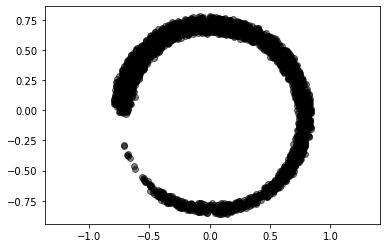

In [22]:
# > visualize the data in a scatter plot.
plt.scatter(x[:, 0], x[:, 1], c="k", alpha=0.5)
plt.axis("equal")

In [39]:
# let's set the noise dimension to 2
Z_DIM = 2

# create a generator as a torch.nn.Module object. (e.g. torch.nn.Sequential(torch.nn.Linear(Z_DIM, 32), ...))
# name this variable G
G = torch.nn.Sequential(
    torch.nn.Linear(Z_DIM, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2)
)

# create a generator as a torch.nn.Module object. (e.g. torch.nn.Sequential(torch.nn.Linear(Z_DIM, 32), ...))
# since this is now called a critic, let's name this variable as C
C = torch.nn.Sequential(
    torch.nn.Linear(2, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)
)

In [40]:
# most of the time you should set the optimizer to Adam optimizer.
# see: https://github.com/soumith/ganhacks by Soumith Chintala et al.

optim_g = torch.optim.Adam(lr=0.0001, params=G.parameters())
optim_c = torch.optim.Adam(lr=0.0001, params=C.parameters())

In [41]:
# some hyperparameters
EPOCH = 1000
# critic (discriminator) training iterations per generator training
CRITIC_ITER = 10
BATCH_SIZE = 50
LOOP_PER_EPOCH = (N // (BATCH_SIZE*CRITIC_ITER))

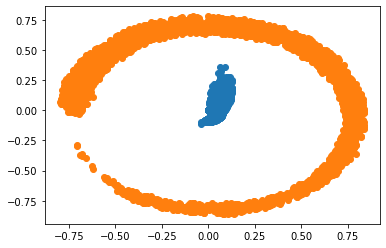

In [42]:
# Firstly, let's see what the generator produces
# before doing any training. Visualize the real
# data and the generated data in a scatter plot.
# you can draw samples from N(0, 1).
with torch.no_grad():
    z = torch.randn(N, Z_DIM)
    x_bar = G(z)
plt.scatter(x_bar[:, 0], x_bar[:, 1])
plt.scatter(x[:, 0], x[:, 1])

In [43]:
# stuff for animation
lims = [min(x[:, 0].min(), x[:, 1].min()), max(x[:, 0].max(), x[:, 1].max())]
lims = [lims[0]-abs(lims[0])*0.2, lims[1]+abs(lims[1])*0.2]
xv, yv = torch.meshgrid(torch.linspace(lims[0], lims[1], 40), torch.linspace(lims[0], lims[1], 40))
field = torch.stack([xv.contiguous().view(-1), yv.contiguous().view(-1)], dim=1)
z_fixed = torch.randn(N, Z_DIM)
timesteps = []
d_fields = []

In [44]:
# let's record the losses after each epoch
C_loss_hist = []
G_loss_hist = []

In [50]:
for e in range(EPOCH):
    C_running_loss = 0.0
    G_running_loss = 0.0
    # for shuffling data
    # e.g. [1, 2, 3, 4, 5] -> [3, 5, 1, 4, 2]
    R = torch.randperm(N)
    for i in range(LOOP_PER_EPOCH):
        ################
        # TRAIN CRITIC #
        ################
        # Since we are trying to optimize
        # the critic up until its optimality
        # (which is not the case with the original
        # GAN because of several gradient issues),
        # we should train the critic more.
        # In practice, training the critic several
        # times per generator step works.
        for c in range(CRITIC_ITER):
            # first, generate some fake data.
            # we should not train G in the critic
            # training loop.
            with torch.no_grad():
                z = torch.randn(BATCH_SIZE, Z_DIM)
                x_fake = G(z)

            # draw some real data.
            x_real = x[R[(CRITIC_ITER*i+c)*BATCH_SIZE:(CRITIC_ITER*i+c+1)*BATCH_SIZE]]

            # compute the critic loss
            # and name it C_loss
            # alternative 1:
            # x1 x2 x3 .. xn -> x_mu
            # y1 y2 y3 .. yn -> y_mu
            # x_mu - y_mu
            # alternative 2:
            # (x1-y1) + (x2-y2) + (x3-y3) + .. + (xn-yn)
            C_loss = (C(x_fake)-C(x_real)).mean() + gradient_penalty(C, x_real, x_fake, 1)

            # reset gradients if there are any
            optim_c.zero_grad()
            # compute gradients
            C_loss.backward()
            # make a gradient descent step for D
            optim_c.step()

            # with torch.no_grad():
            #     for p in C.parameters():
            # if not relu !!
            #         p.weight.data.clamp_(-0.01, 0.01)

            # log
            C_running_loss += C_loss.item()

        #######################
        #   TRAIN GENERATOR   #
        #######################

        # first, stop the unnecessary gradient computation
        # for the critic, as we are optimizing for G.
        for p in C.parameters():
            p.requires_grad = False

        z = torch.randn(BATCH_SIZE, Z_DIM)
        # first, generate some fake data.
        x_fake = G(z)
        # compute the generator loss and name it G_loss
        G_loss = -C(x_fake).mean()

        # compute gradients
        optim_g.zero_grad()
        G_loss.backward()
        # gradient descent step
        optim_g.step()
        # log
        G_running_loss += G_loss.item()

        # now we can open the gradient valves for C.
        for p in C.parameters():
            p.requires_grad = True

    # record the generated data and critic outputs
    # after each epoch
    G.eval()
    C.eval()
    with torch.no_grad():
        disc_field = torch.sigmoid(C(field)).numpy()
        indexes = (disc_field*100).astype(np.int32).reshape(-1)
        d_fields.append(indexes)
        data = np.zeros((N * 2,2))
        data[:N] = x.cpu()
        data[N:] = G(z_fixed).numpy()
        timesteps.append(data)
    C.train()
    G.train()

    C_running_loss /= LOOP_PER_EPOCH
    C_loss_hist.append(C_running_loss)
    G_running_loss /= LOOP_PER_EPOCH
    G_loss_hist.append(G_running_loss)

    print("Epoch: %d - C loss: %.5f, G loss: %.5f" % (e+1, C_running_loss, G_running_loss))

Epoch: 1 - C loss: 0.33368, G loss: 0.52506
Epoch: 2 - C loss: -5.07604, G loss: 0.89367
Epoch: 3 - C loss: -5.88179, G loss: 0.97335
Epoch: 4 - C loss: -6.03115, G loss: 0.99861
Epoch: 5 - C loss: -5.57012, G loss: 0.93395
Epoch: 6 - C loss: -5.40650, G loss: 0.89161
Epoch: 7 - C loss: -5.00679, G loss: 0.80731
Epoch: 8 - C loss: -4.54917, G loss: 0.77193
Epoch: 9 - C loss: -3.99174, G loss: 0.65577
Epoch: 10 - C loss: -3.68727, G loss: 0.60511
Epoch: 11 - C loss: -3.18185, G loss: 0.52085
Epoch: 12 - C loss: -2.74226, G loss: 0.42912
Epoch: 13 - C loss: -2.26004, G loss: 0.36515
Epoch: 14 - C loss: -1.76471, G loss: 0.31753
Epoch: 15 - C loss: -1.45687, G loss: 0.26906
Epoch: 16 - C loss: -0.97541, G loss: 0.19030
Epoch: 17 - C loss: -0.66667, G loss: 0.11206
Epoch: 18 - C loss: -0.20574, G loss: 0.11554
Epoch: 19 - C loss: 0.09096, G loss: 0.03033
Epoch: 20 - C loss: 0.52783, G loss: 0.01319
Epoch: 21 - C loss: 0.90759, G loss: -0.04197
Epoch: 22 - C loss: 1.19812, G loss: -0.10465


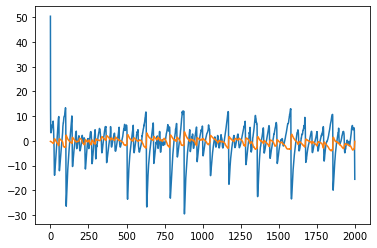

In [51]:
# plot the losses
plt.plot(C_loss_hist)
plt.plot(G_loss_hist)

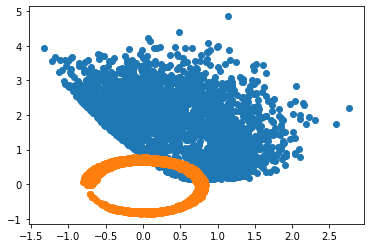

In [52]:
# Let's see what the generator produces after training
# Visualize the real data and the generated data
# in a scatter plot.
G.eval().cpu()
with torch.no_grad():
    z = torch.randn(N, Z_DIM)
    x_bar = G(z)
plt.scatter(x_bar[:, 0], x_bar[:, 1])
plt.scatter(x[:, 0], x[:, 1])

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


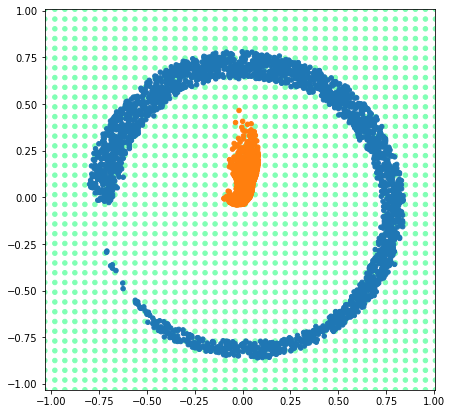

In [53]:
# render
anim = save_animation(timesteps, d_fields, lims=lims)

In [ ]:
# let's visualize the training process
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(5, 1))
plt.xlabel("Critic Output")
plt.xticks([0, 50, 100, 150, 200, 250], ["0", "0.2", "0.4", "0.6", "0.8", "1.0"])
plt.yticks([])
plt.imshow(gradient, aspect="auto", cmap=plt.get_cmap("rainbow"))
# convert to html5 video
# this might take a time
HTML(anim.to_html5_video())

# orange points are the generated data
# blue points are the real data

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


# What's next?

* You can try the original Wasserstein GAN: clipping weights for Lipschitz regularity instead of gradient penalty (i.e. weight.data.clamp(-0.01, 0.01) after each update)
* Try for different critic iterations.